In [ ]:
!pip install -q igraph leidenalg  # For clustering

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from torchviz import make_dot
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
from GraphST.graphst import GraphST
from GraphST.utils import clustering
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.explain import Explainer, GNNExplainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/amintehrani/.pyenv/versions/3.12.8/envs/torchgeo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [5]:
adata = sq.read.visium("./dataset/V1_Human_Lymph_Node")
adata

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata.obs.index.unique()

Index(['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACACCAATAACTGC-1',
       'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1',
       'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1',
       'AAACCGGGTAGGTACC-1',
       ...
       'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1',
       'TTGTTGGCAATGACTG-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1',
       'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1', 'TTGTTTGTATTACACG-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=4035)

In [8]:
graphclust = pd.read_csv("dataset/V1_Human_Lymph_Node/analysis/clustering/graphclust/clusters.csv")
graphclust.set_index("Barcode", inplace=True)
adata.obs['graphclust'] = graphclust['Cluster'] - 1

In [9]:
gst = GraphST(adata, device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu"))

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
from GraphST.model import AvgReadout, Encoder
print(torch.tensor([[1, 2,3,4,5],[ 1,2,3, 4,5]], dtype=torch.float32, device=device).shape)
AvgReadout().forward(
    torch.tensor([[1, 2,3,4,5],[ 1,2,3, 4,5]], dtype=torch.float32, device=device),
    torch.tensor([[1, 2],[ 1,2]], dtype=torch.float32, device=device),
    )

gst.model = Encoder(gst.dim_input, gst.dim_output, gst.graph_neigh).to(gst.device)
print(gst.graph_neigh.shape)
print(gst.model(gst.features, gst.features_a, gst.adj)[0].shape)

torch.Size([2, 5])
torch.Size([4035, 4035])
torch.Size([4035, 64])


/home/amintehrani/.pyenv/versions/3.12.8/envs/torchgeo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from GraphST.graphst import Encoder
from torchinfo import summary
model = Encoder(gst.dim_input, gst.dim_output, gst.graph_neigh).to(gst.device)



# summary(model, input_data=(gst.features,gst.features_a, gst.adj), device=device.type,)
# Create dummy input (adjust shape based on your model's expected input)
# dummy_input = torch.randint(0, 3000, (1,)).to(device)  # for example, a single token if it's an embedding-based model

# # Forward pass
output = model(gst.features,gst.features_a, gst.adj)

# # Visualize computation graph
make_dot(output, params=dict(model.named_parameters())).render("GraphST_architecture", format="png")

'GraphST_architecture.png'

In [11]:
gadata = gst.train()

Begin to train ST data...


 66%|██████▌   | 396/600 [01:33<00:47,  4.26it/s]


KeyboardInterrupt: 

In [9]:
clustering(gadata, method="leiden")

Searching resolution...


/home/amintehrani/.pyenv/versions/3.12.8/envs/torchgeo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/GraphST/utils.py:223: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, random_state=0, resolution=res)


resolution=2.9899999999999984, cluster number=35
resolution=2.9799999999999986, cluster number=36
resolution=2.969999999999999, cluster number=34
resolution=2.9599999999999986, cluster number=34
resolution=2.949999999999999, cluster number=34
resolution=2.9399999999999986, cluster number=33
resolution=2.929999999999999, cluster number=32
resolution=2.9199999999999986, cluster number=32
resolution=2.909999999999999, cluster number=31
resolution=2.8999999999999986, cluster number=32
resolution=2.889999999999999, cluster number=33
resolution=2.8799999999999986, cluster number=33
resolution=2.8699999999999988, cluster number=34
resolution=2.8599999999999985, cluster number=34
resolution=2.8499999999999988, cluster number=32
resolution=2.8399999999999985, cluster number=33
resolution=2.8299999999999987, cluster number=32
resolution=2.819999999999999, cluster number=33
resolution=2.8099999999999987, cluster number=33
resolution=2.799999999999999, cluster number=31
resolution=2.78999999999999

In [10]:
G = nx.from_numpy_array(gadata.obsm['adj'])

In [13]:
hires_scale = adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Anterior']['scalefactors']['tissue_hires_scalef']
coords_hires = adata.obsm['spatial'] * hires_scale
pos = coords_hires

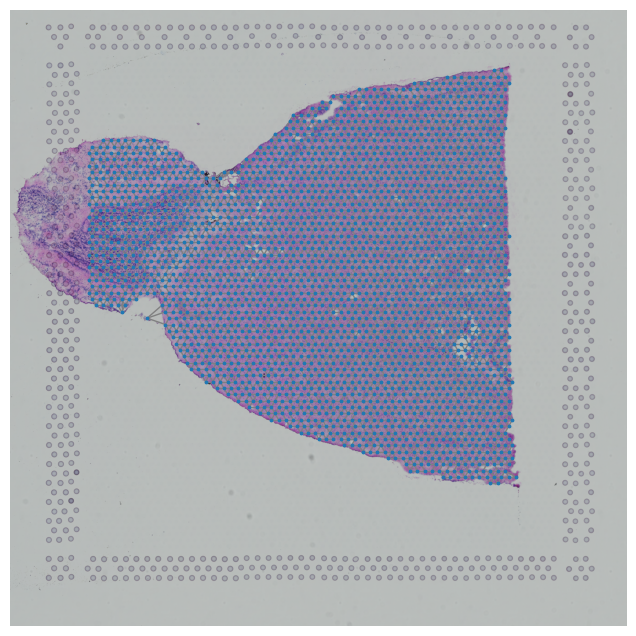

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Anterior']['images']['hires'])
ax.invert_yaxis()
ax.axis('off')
nx.draw(G, pos=pos, node_size=3, edge_color='gray', with_labels=False, ax=ax)
plt.show()

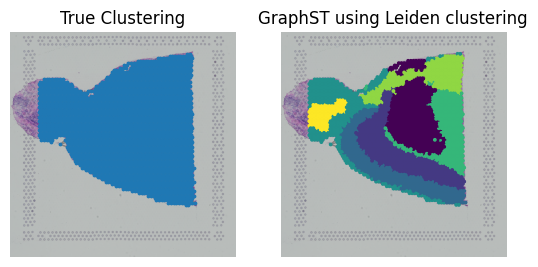

In [18]:
ax = plt.subplot(1, 2, 1)
ax.imshow(adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Anterior']['images']['hires'])
ax.invert_yaxis()
ax.axis('off')
nx.draw(G, pos=pos, node_size=3, edge_color='gray', with_labels=False, ax=ax)
ax.set_title("True Clustering")

ax = plt.subplot(1, 2, 2)
ax.imshow(adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Anterior']['images']['hires'])
ax.invert_yaxis()
ax.axis('off')
nx.draw(G, pos=pos, node_size=3, node_color=gadata.obs['leiden'].astype(int).tolist(), edge_color='gray', with_labels=False, ax=ax)
ax.set_title("GraphST using Leiden clustering")


plt.show()

In [2]:
adata

NameError: name 'adata' is not defined

In [19]:
gst.train_sc()

Begin to train scRNA data...


  0%|          | 0/600 [00:00<?, ?it/s]

AttributeError: 'GraphST' object has no attribute 'feat_sc'